# This notebook demonstrates the usage of `synthesis_general()` on a GPU and on a CPU
You'll be generating random data, random new non-uniform location, and calculate the synthesized SHT map at this location.
Note that the calls are slightly different for the two backends.

In [1]:
from IPython.display import clear_output
import numpy as np
import cupy as cp

import healpy as hp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cunusht
from cunusht.utils import synalm, Alm

from scipy.special import comb
def get_coef(plot_fid=False):
    def smoothstep(x, x_min=0, x_max=1, N=1):
        x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
        result = 0
        for n in range(0, N + 1):
            result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
        result *= x ** (N + 1)
        return result

    ll = np.arange(0,lmax+1)
    cl = (1+np.sin(ll/3)**2)*smoothstep(ll, lmax//50)
    if plot_fid:
        plt.plot(cl)
        plt.loglog()
    return synalm(cl, lmax=lmax, mmax=lmax)

[SHTns 3.6.6] built Apr  8 2024, 07:59:49, id: v3.6.6-10-g3986338*,avx512,ishioka,openmp,cuda


## Initialise

In the first cell, you set up some parameters and initialise the transformer that holds all relevant functions. 

`geominfo` is the geometry onto which the final map is calculated. We choose a 'Gauss-Legendre' geometry due to it obeying a sampling theorem.
We also demonstrate nuFFT-planning by providing 'nuFFTtype' and 'epsilon', so that we can calculate `synthesis_general()` without having to repeatedly initialise it.

In [2]:
lmax, mmax = 2047, 2047
geominfo = ('gl',{'lmax': lmax})
kwargs = {
    'geominfo_deflection': geominfo,
    'nuFFTtype': 2,
    'epsilon': 1e-7,
}

tGPU = cunusht.get_transformer(backend='GPU')(**kwargs)

clear_output()

## Generate data
You will need SHT coefficients `coef` at a uniform-grid, and the non-uniform `pointing` grid at which the map is supposed to be evaluated.

First, we create random coefs, but supress small scales to give it some structure, and view them.

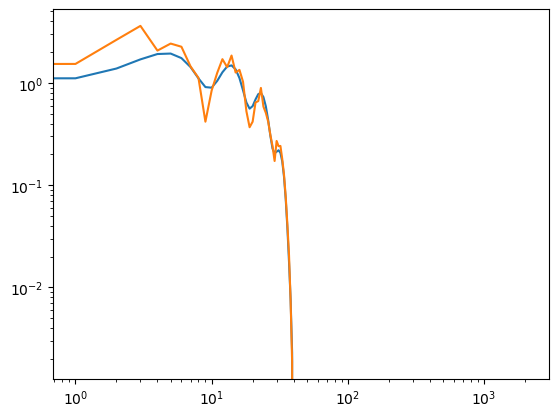

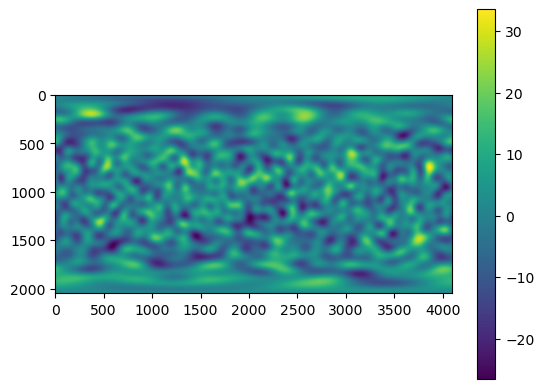

In [3]:
coef = get_coef(True)
plt.plot(hp.alm2cl(coef))
plt.loglog()
plt.show()

m = cp.empty(tGPU.npix())
tGPU.synthesis(cp.array(coef), out=m, lmax=lmax, mmax=lmax)
plt.imshow(m.get().reshape(-1,lmax+1).T)
plt.colorbar()

Then, for the pointing we choose something simple, like a `sin()` function that shifts all theta locations away from the uniform grid by a small amount. We also provide a refernce pointing `loc_nod` that does exactly no remapping.

In [21]:
loc = tGPU.get_grid_uniform()

pointing_theta = (loc[0,:].reshape(lmax+1,-1)+0.05*cp.sin(2*np.pi/3*cp.linspace(0,np.pi,lmax+1)).reshape(-1,1)**2*cp.sin(2*2*np.pi*cp.linspace(0,np.pi,lmax+1).reshape(-1,1))).flatten()
pointing_phi = loc[1,:]
pointing_theta = cp.where(pointing_theta>np.pi,pointing_theta-np.pi, pointing_theta)
pointing_theta = cp.where(pointing_theta<0,pointing_theta+np.pi, pointing_theta)
pointing_phi = cp.where(pointing_phi>2*np.pi,pointing_phi-2*np.pi, pointing_phi)
pointing_phi = cp.where(pointing_phi<0,pointing_phi+2*np.pi, pointing_phi)
loc = cp.array([pointing_theta, pointing_phi])

loc_nod = tGPU.get_grid_uniform()

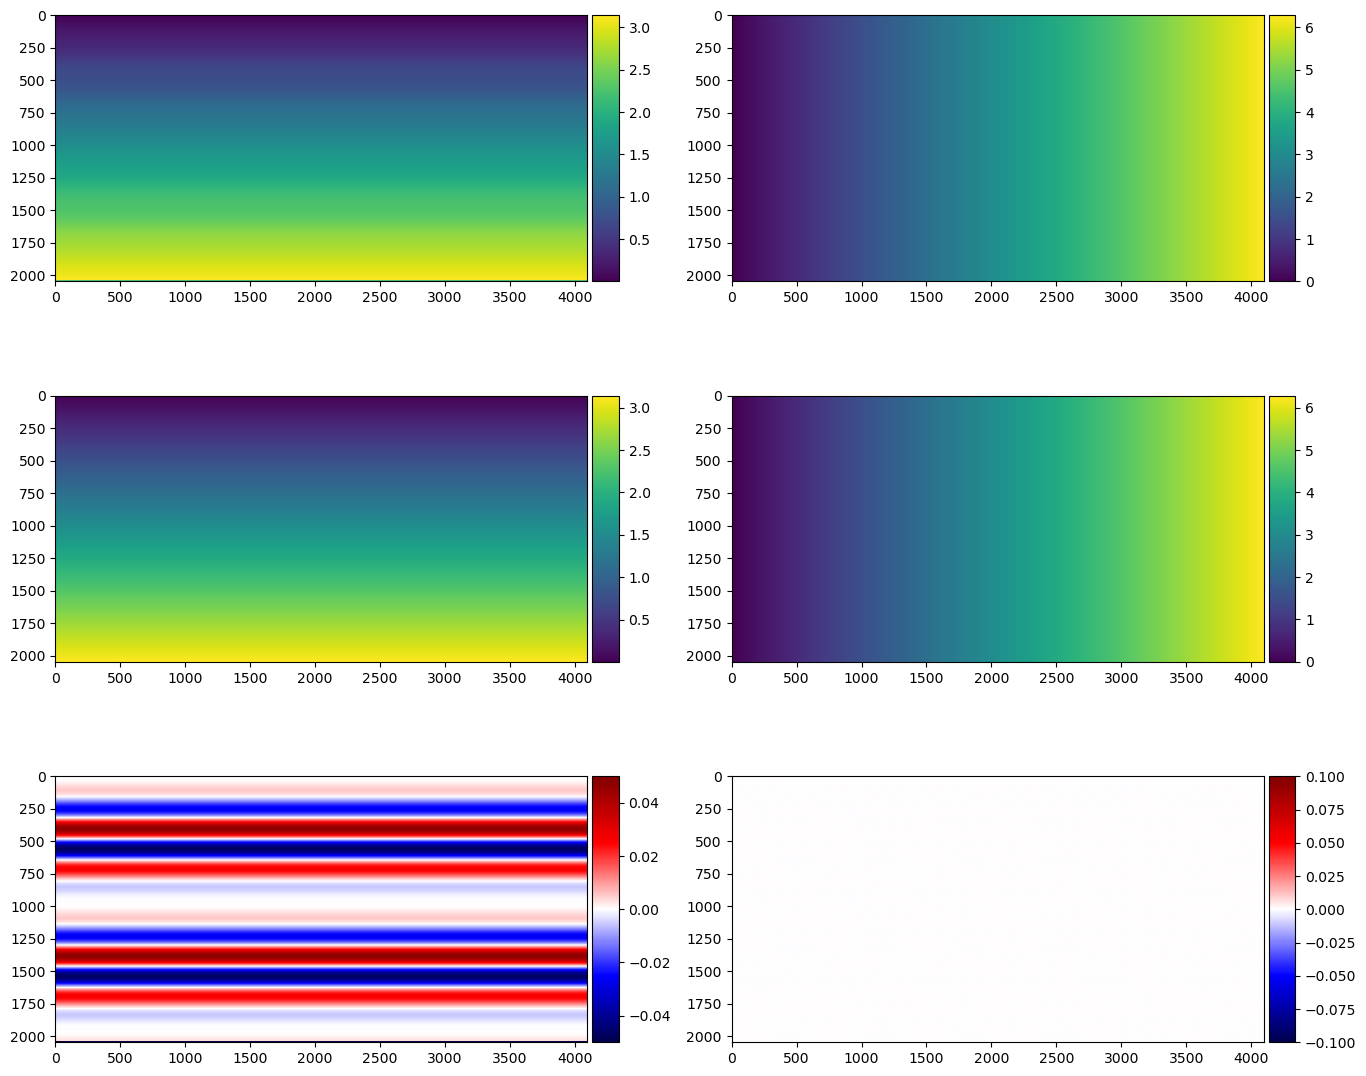

In [22]:
def add_colorbar_to_axis(fig, ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
fig, ax = plt.subplots(3, 2, figsize=(16,14))

im = ax[0,0].imshow(loc[0,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0,0], im)

im = ax[0,1].imshow(loc[1,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0,1], im)

im = ax[1,0].imshow(loc_nod[0,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1,0], im)

im = ax[1,1].imshow(loc_nod[1,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1,1], im)

im = ax[2,0].imshow((loc[0,:]-loc_nod[0,:]).get().reshape(lmax+1,-1), vmin=-0.05,vmax=0.05, cmap='seismic')
add_colorbar_to_axis(fig, ax[2,0], im)

im = ax[2,1].imshow((loc[1,:]-loc_nod[1,:]).get().reshape(lmax+1,-1), cmap='seismic')
add_colorbar_to_axis(fig, ax[2,1], im)

## Let's calculate the new map
you can choose `loc` or `loc_nod` here and check what happens

In [23]:
pointmap = cp.empty(shape=tGPU.npix())*0.
res = tGPU.synthesis_general(lmax=lmax, mmax=mmax, alm=cp.array(coef), loc=cp.array(loc.T), epsilon=kwargs['epsilon'], pointmap=pointmap, verbose=True)

# want:
# t.get_shape('alm' or 'map') # returns shape of arrays for synth_gen calls, eg:
# alm = cp.empty(shape=t.get_shape('alm'))
# pointmap = cp.empty(shape=t.get_shape('map'))

# alm, loc, and map in any shape and dtype

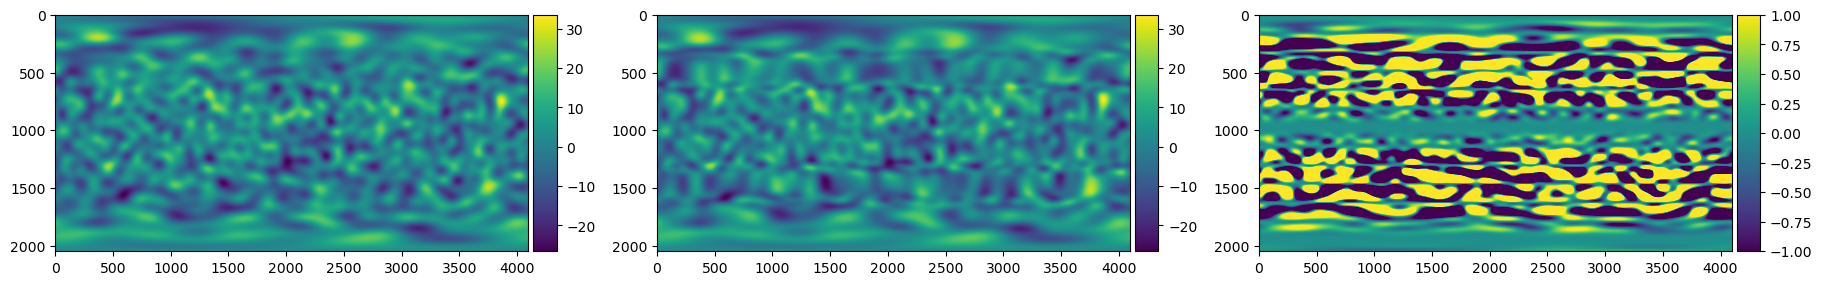

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(22,12))

im = ax[0].imshow(m.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[0], im)

im = ax[1].imshow(res.get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1], im)

epsilon = kwargs['epsilon']*1e7
im = ax[2].imshow(m.get().reshape(-1,lmax+1).T-res.get().reshape(lmax+1,-1), vmin=-epsilon, vmax=epsilon)
add_colorbar_to_axis(fig, ax[2], im)

### We can use this transformer to repeatedly call `synthesis_general()`, which is not only conventient, but also fast. No more initialisation needed, you can even change the `loc` in each call, if wanted.

In [8]:
for n in range(5):
    res = tGPU.synthesis_general(lmax=lmax, mmax=mmax, alm=cp.array(get_coef(False)), loc=cp.array(loc_nod.T), epsilon=kwargs['epsilon'], pointmap=pointmap, verbose=True)
    print(res)

[12.98485402 12.98505402 12.98525437 ...  6.57122812  6.57113038
  6.5710323 ]
[0.33428712 0.3345422  0.33479734 ... 4.72419177 4.72441227 4.72463268]
[-5.23034979 -5.23012909 -5.22990907 ...  7.11021726  7.11035157
  7.11048578]
[-6.81359438 -6.8134581  -6.81332161 ... 11.7363606  11.73646142
 11.73656257]
[-4.62081444 -4.62074879 -4.6206833  ... -6.58772429 -6.58770789
 -6.58769084]


## gclm2lenmap()
This is a convenience function in case you have a deflection field, which is likely the case if you are a CMB lensing analyst. The following cell uses a deflection field that is zero, therefore you won't see any deflection. Feel free to create your own toy deflection field

In [14]:
pointmap = cp.empty(shape=tGPU.npix())*0.
res = tGPU.gclm2lenmap(cp.array(coef), dlm_scaled=cp.zeros(shape=coef.shape), lmax=lmax, mmax=lmax, lenmap=pointmap)#, ptg=cp.array(loc_nod.T))

Running in normal execution mode
- - - - - - - - - - - - - - - Timing gclm2lenmap: 0.263 seconds- - - - - - - - - - - - - - - 



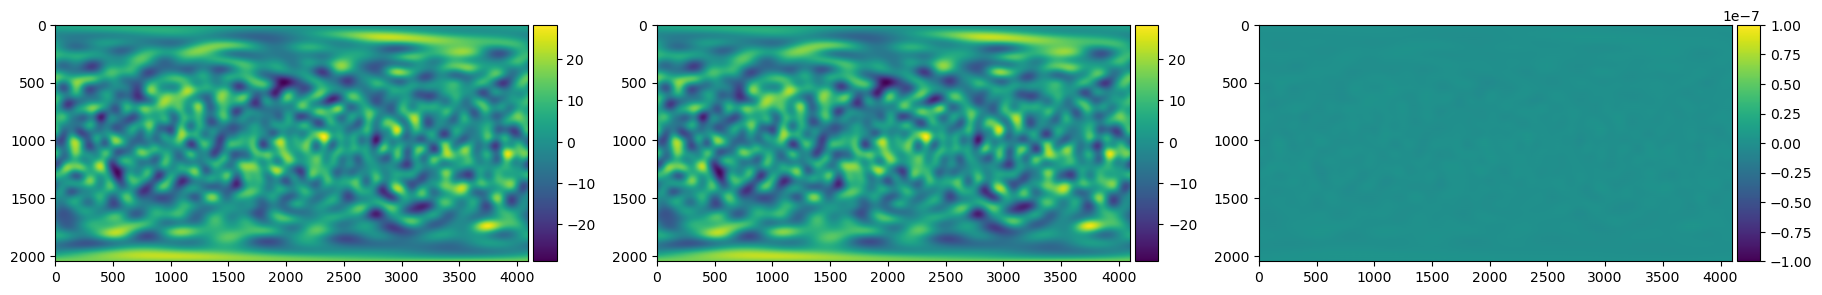

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(22,12))

im = ax[0].imshow(m.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[0], im)

im = ax[1].imshow(res.get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1], im)

epsilon = kwargs['epsilon']
im = ax[2].imshow(m.get().reshape(-1,lmax+1).T-res.get().reshape(lmax+1,-1), vmin=-epsilon, vmax=epsilon)
add_colorbar_to_axis(fig, ax[2], im)

# CPU
In case you'd like to run these functions on the CPU, the following cells show how that would work.

The following cell creates a transformer with the CPU as backend

In [ ]:
lmax, mmax = 2047, 2047
geominfo = ('gl',{'lmax':lmax})
kwargs = {
    'geominfo_deflection':  geominfo,
}

tCPU = cunusht.get_transformer(backend='CPU')(**kwargs)
dglm = np.empty(Alm.getsize(lmax, mmax))*0.
tCPU.setup_lensing(dglm, mmax_dlm=mmax, nthreads=10, verbose=False, epsilon=1e-6, single_prec=False)

clear_output()

## Generate data
This is exactly as in the GPU case

In [ ]:
coef = get_coef(True)

In [ ]:
m = tCPU.deflectionlib.geom.synthesis(coef.copy(), spin=0, lmax=lmax, mmax=lmax, nthreads=10)
plt.imshow(m.reshape(lmax+1,-1))

## Let's get the result

In [ ]:
pointmap = np.empty(tCPU.deflectionlib.geom.npix())
res = tCPU.synthesis_general(lmax=lmax, mmax=lmax, alm=np.array(np.atleast_2d(coef)), spin=0, mode="STANDARD", loc=np.array(loc).T, epsilon=1e-10, nthreads=10, verbose=0)

note: the difference map is only expected to be at the order of epsilon, if there is no deflection, i.e. if you use `loc_nod`

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,12))

im = ax[0].imshow(m.reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0], im)

im = ax[1].imshow(res.reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1], im)

epsilon=1e-11
im = ax[2].imshow(m.reshape(lmax+1,-1)-res.reshape(lmax+1,-1), vmin=-epsilon, vmax=epsilon)
add_colorbar_to_axis(fig, ax[2], im)

## gclm2lenmap()

In [ ]:
pointmap = np.empty(shape=tGPU.deflectionlib.geom.npix())*0.
res = tCPU.gclm2lenmap(gclm=np.array(coef), dlm=np.zeros(shape=coef.shape, dtype=np.complex128), spin=0, lmax=lmax, mmax=lmax, nthreads=10, epsilon=1e-7, lenmap=pointmap)#, ptg=cp.array(loc_nod.T))